# 새 섹션

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 설정
sr = 16000
n_fft = 512
hop_length = 160
target_size = (224, 224)

# 입력 폴더
input_root = '/content/drive/MyDrive/cat_sound_processing'
# 저장 폴더
output_root = '/content/drive/MyDrive/cat_stft_224_224'

# 전체 클래스 폴더
folders = [f for f in os.listdir(input_root) if os.path.isdir(os.path.join(input_root, f))]

for folder in folders:
    input_folder_path = os.path.join(input_root, folder)
    output_folder_path = os.path.join(output_root, folder)
    os.makedirs(output_folder_path, exist_ok=True)

    files = [f for f in os.listdir(input_folder_path) if f.endswith('.wav')]

    for file in files:
        input_path = os.path.join(input_folder_path, file)
        output_path = os.path.join(output_folder_path, file.replace('.wav', '.png'))

        # 오디오 로드
        y, _ = librosa.load(input_path, sr=sr)

        # STFT 변환
        D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
        S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

        # 0~1로 정규화
        S_db_norm = (S_db - np.min(S_db)) / (np.max(S_db) - np.min(S_db))
        S_db_img = (S_db_norm * 255).astype(np.uint8)

        # y축 뒤집기 (고주파가 위로 오게)
        S_db_img = np.flip(S_db_img, axis=0)

        # 크기 조정
        resized_img = cv2.resize(S_db_img, target_size)

        # 저장
        cv2.imwrite(output_path, resized_img)

print("✅ STFT 변환 및 저장 완료!")


✅ STFT 변환 및 저장 완료!


In [33]:
import os
import json
import numpy as np
import random
import math

# 🐾 설정
base_path = "/content/drive/MyDrive/cat_move"
selected_classes = ["ARMSTRETCH", "GROOMING", "LAYDOWN", "SITDOWN", "TAILING", "WALKRUN"]
class_mapping = {cls: idx for idx, cls in enumerate(selected_classes)}

# 🐾 증강 함수들
def augment_translation(keypoints, max_shift=0.02):  # 정규화됐으니까 살짝만
    shift_x = random.uniform(-max_shift, max_shift)
    shift_y = random.uniform(-max_shift, max_shift)
    keypoints[:, :, 0] += shift_x
    keypoints[:, :, 1] += shift_y
    return keypoints

def augment_scaling(keypoints, scale_range=(0.95, 1.05)):
    scale = random.uniform(*scale_range)
    center = np.mean(keypoints, axis=1, keepdims=True)
    keypoints = (keypoints - center) * scale + center
    return keypoints

def augment_rotation(keypoints, max_angle=5):
    angle = math.radians(random.uniform(-max_angle, max_angle))
    cos_val = math.cos(angle)
    sin_val = math.sin(angle)
    center = np.mean(keypoints, axis=1, keepdims=True)
    rotated = keypoints - center
    x = rotated[:, :, 0]
    y = rotated[:, :, 1]
    rotated[:, :, 0] = cos_val * x - sin_val * y
    rotated[:, :, 1] = sin_val * x + cos_val * y
    return rotated + center

def augment_jitter(keypoints, noise_std=0.01):
    noise = np.random.normal(0, noise_std, size=keypoints.shape)
    return keypoints + noise

def apply_augmentation(keypoints):
    funcs = [augment_translation, augment_scaling, augment_rotation, augment_jitter]
    random.shuffle(funcs)
    for f in funcs[:random.randint(2, 3)]:
        keypoints = f(keypoints)
    return keypoints

# 🐾 관절 추출 + 정규화 함수
def extract_keypoints(json_path, target_frames=100, joint_num=15):
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    annotations = data.get("annotations", [])
    frames = []

    for ann in annotations:
        keypoints = ann.get("keypoints", {})
        bbox = ann.get("bounding_box", None)

        frame_kps = []

        if bbox is None:
            # bbox 없으면 그냥 (0,0) 채워서 넘어간다
            frame_kps = [[0.0, 0.0] for _ in range(joint_num)]
        else:
            bbox_x = bbox.get("x", 0)
            bbox_y = bbox.get("y", 0)
            bbox_width = bbox.get("width", 1e-6)  # 0으로 나누지 않게 아주 작은 값
            bbox_height = bbox.get("height", 1e-6)

            for joint_id in range(1, joint_num + 1):
                joint_id_str = str(joint_id)
                if joint_id_str in keypoints and keypoints[joint_id_str] is not None:
                    coord = keypoints[joint_id_str]
                    norm_x = (coord["x"] - bbox_x) / bbox_width
                    norm_y = (coord["y"] - bbox_y) / bbox_height
                    frame_kps.append([norm_x, norm_y])
                else:
                    frame_kps.append([0.0, 0.0])

        frames.append(frame_kps)

    frames = np.array(frames, dtype=np.float32)  # (frame 수, 관절 수, 2)

    if len(frames) == 0:
        return None

    num_frames, num_joints, _ = frames.shape

    # 100프레임 맞추기
    if num_frames >= target_frames:
        frames = frames[:target_frames]
    else:
        repeat_times = (target_frames - num_frames) // num_frames
        remainder = (target_frames - num_frames) % num_frames
        frames = np.concatenate(
            [frames] * (1 + repeat_times) + [frames[:remainder]],
            axis=0
        )

    assert frames.shape[0] == target_frames
    return frames  # (100, 관절 수, 2)

# 🐾 데이터셋 구축
X_list = []
y_list = []

for action_class in selected_classes:
    action_path = os.path.join(base_path, action_class)
    if not os.path.isdir(action_path):
        continue

    all_samples = []

    for item in os.listdir(action_path):
        if not item.endswith(".json"):
            continue

        json_path = os.path.join(action_path, item)
        frames = extract_keypoints(json_path)

        if frames is not None:
            all_samples.append(frames)

    original_count = len(all_samples)
    print(f"🔵 {action_class}: 원본 {original_count}개")

    if original_count == 0:
        continue

    # 300개 맞추기
    while len(all_samples) < 300:
        idx = random.randint(0, original_count - 1)
        augmented = apply_augmentation(all_samples[idx].copy())
        all_samples.append(augmented)

    random.shuffle(all_samples)
    all_samples = all_samples[:300]

    X_list.extend(all_samples)
    y_list.extend([class_mapping[action_class]] * 300)

# 🐾 numpy 변환
X = np.array(X_list, dtype=np.float32)  # (샘플 수, 100, 관절 수, 2)
y = np.array(y_list, dtype=np.int64)    # (샘플 수,)

print("✅ 최종 데이터셋 크기:", X.shape, y.shape)

# 🐾 저장
np.save("/content/drive/MyDrive/cat_move/X_stgcn_normalized.npy", X)
np.save("/content/drive/MyDrive/cat_move/y_stgcn_normalized.npy", y)

print("✅ 저장 완료: X_stgcn_normalized.npy, y_stgcn_normalized.npy")

🔵 ARMSTRETCH: 원본 369개
🔵 GROOMING: 원본 648개
🔵 LAYDOWN: 원본 217개
🔵 SITDOWN: 원본 184개
🔵 TAILING: 원본 389개
🔵 WALKRUN: 원본 323개
✅ 최종 데이터셋 크기: (1800, 100, 15, 2) (1800,)
✅ 저장 완료: X_stgcn_normalized.npy, y_stgcn_normalized.npy


# 새 섹션

In [34]:
!pip install onnx onnxruntime

In [35]:
import onnx
import onnxruntime as ort

# 1. ONNX 모델 불러오기
model_path = '/content/drive/MyDrive/pyramid_fusion_model_middle_concat_last_2layer.onnx'
session = ort.InferenceSession(model_path)

# 2. 입력 정보 확인
for i, inp in enumerate(session.get_inputs()):
    print(f"Input {i}: name={inp.name}, shape={inp.shape}, type={inp.type}")

# 3. 출력 정보 확인
for o, out in enumerate(session.get_outputs()):
    print(f"Output {o}: name={out.name}, shape={out.shape}, type={out.type}")

Input 0: name=pose_input, shape=['batch_size', 2, 100, 15], type=tensor(float)
Input 1: name=sound_input, shape=['batch_size', 3, 224, 224], type=tensor(float)
Output 0: name=action_output, shape=['batch_size', 6], type=tensor(float)
Output 1: name=emotion_output, shape=['batch_size', 4], type=tensor(float)


  plt.tight_layout()

  plt.tight_layout()

  plt.tight_layout()

  plt.tight_layout()

  plt.tight_layout()

  plt.tight_layout()

  plt.tight_layout()

  plt.tight_layout()

  plt.tight_layout()

  plt.tight_layout()

  plt.tight_layout()

  plt.tight_layout()

  plt.tight_layout()

  plt.tight_layout()

  plt.tight_layout()

  plt.tight_layout()

  plt.tight_layout()

  fig.canvas.print_figure(bytes_io, **kw)

  fig.canvas.print_figure(bytes_io, **kw)

  fig.canvas.print_figure(bytes_io, **kw)

  fig.canvas.print_figure(bytes_io, **kw)

  fig.canvas.print_figure(bytes_io, **kw)

  fig.canvas.print_figure(bytes_io, **kw)

  fig.canvas.print_figure(bytes_io, **kw)

  fig.canvas.print_figure(bytes_io, **kw)

  fig.canvas.print_figure(bytes_io, **kw)

  fig.canvas.print_figure(bytes_io, **kw)

  fig.canvas.print_figure(bytes_io, **kw)

  fig.canvas.print_figure(bytes_io, **kw)

  fig.canvas.print_figure(bytes_io, **kw)

  fig.canvas.print_figure(bytes_io, **kw)

  fig.canvas.print_figur

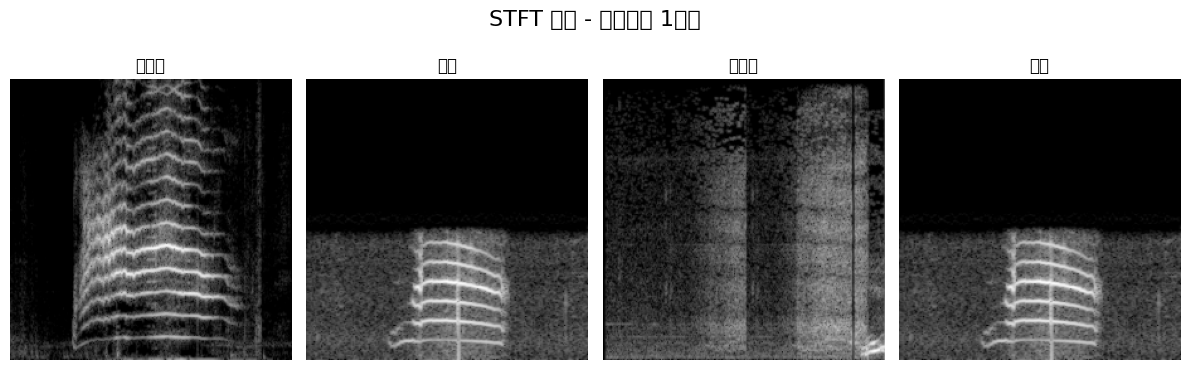

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# 🔄 데이터 로드
X_sound = np.load("/content/drive/MyDrive/cat_stft_224_224/stft_X.npy")  # (N, 224, 224, 3)
y_sound = np.load("/content/drive/MyDrive/cat_stft_224_224/stft_y.npy")  # (N,)

# 😺 클래스 이름 정의 (예시)
class_names = ['하악질', '편안', '골골송', '화남']  # 클래스 0~3

# ✅ 각 클래스별 첫 번째 이미지 인덱스 추출
selected_indices = []
for class_id in range(len(class_names)):
    indices = np.where(y_sound == class_id)[0]
    if len(indices) > 0:
        selected_indices.append(indices[0])

# 🎨 플롯
plt.figure(figsize=(12, 4))
for i, idx in enumerate(selected_indices):
    plt.subplot(1, len(selected_indices), i + 1)
    img = X_sound[idx]
    plt.imshow(img)
    plt.title(f"{class_names[y_sound[idx]]}")
    plt.axis('off')

plt.suptitle("STFT 예시 - 클래스별 1개씩", fontsize=16)
plt.tight_layout()
plt.show()

In [37]:
import numpy as np

# 🔄 STFT 데이터 로드
X_sound = np.load("/content/drive/MyDrive/cat_stft_224_224/stft_X.npy")  # (N, 224, 224, 3)

# ✅ 채널 수 확인
print("전체 shape:", X_sound.shape)
sample = X_sound[0]
print("샘플 이미지 shape:", sample.shape)

# ✅ 3채널이 동일한 값인지 확인
ch0 = sample[:, :, 0]
ch1 = sample[:, :, 1]
ch2 = sample[:, :, 2]

# 세 채널의 차이가 있는지 확인
print("ch0 - ch1 max diff:", np.max(np.abs(ch0 - ch1)))
print("ch0 - ch2 max diff:", np.max(np.abs(ch0 - ch2)))

전체 shape: (1800, 224, 224, 3)
샘플 이미지 shape: (224, 224, 3)
ch0 - ch1 max diff: 0.0
ch0 - ch2 max diff: 0.0


✅ 오디오 로드 완료 - 총 길이: 4.76초
🎯 잘라낸 구간: 0.18초 ~ 3.18초


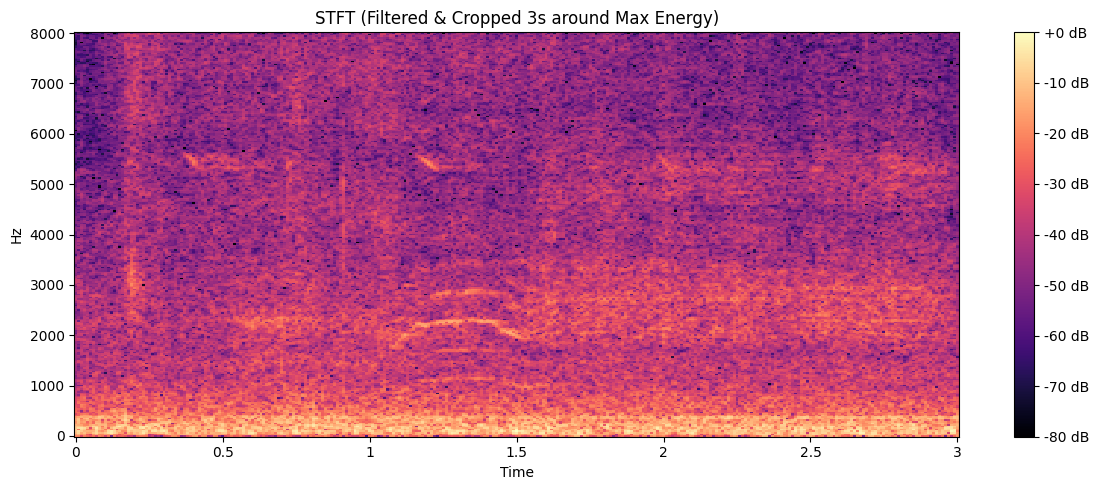

In [38]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import moviepy.editor as mp
import os
import numpy as np
from scipy.signal import butter, sosfilt
# 🎬 비디오에서 오디오 추출
video_path = "/content/20250502_164515_1_1.mp4"
audio_path = "/content/20250502_164515_1_1_audio.wav"
clip = mp.VideoFileClip(video_path)
clip.audio.write_audiofile(audio_path, fps=16000, verbose=False, logger=None)

# 🔊 오디오 로드
y, sr = librosa.load(audio_path, sr=16000)
print(f"✅ 오디오 로드 완료 - 총 길이: {len(y)/sr:.2f}초")

# 🧼 Band-pass filter: 20~12000Hz
def bandpass_filter(data, sr, lowcut=20.0, highcut=16000.0, order=5):
    sos = butter(order, [lowcut, highcut], btype='band', fs=sr, output='sos')
    return sosfilt(sos, data)

y_filtered = bandpass_filter(y, sr, lowcut=20.0, highcut=7999.0)

# 🔍 에너지가 가장 높은 3초 구간 추출
frame_length = int(0.05 * sr)  # 50ms
hop_length_energy = int(0.01 * sr)  # 10ms
energy = librosa.feature.rms(y=y_filtered, frame_length=frame_length, hop_length=hop_length_energy)[0]
energy_times = librosa.frames_to_time(np.arange(len(energy)), sr=sr, hop_length=hop_length_energy)

# 최대 에너지 시점 탐색
max_energy_index = np.argmax(energy)
center_time = energy_times[max_energy_index]
start_time = max(0, center_time - 1.5)  # 3초 구간의 중심
end_time = min(len(y_filtered)/sr, start_time + 3.0)

# 샘플 인덱스 변환
start_sample = int(start_time * sr)
end_sample = int(end_time * sr)
y_cropped = y_filtered[start_sample:end_sample]
print(f"🎯 잘라낸 구간: {start_time:.2f}초 ~ {end_time:.2f}초")

# 🎚️ STFT 시각화
n_fft = 512
hop_length = 160
D = librosa.stft(y_cropped, n_fft=n_fft, hop_length=hop_length)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure(figsize=(12, 5))
librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='linear', cmap='magma')
plt.colorbar(format="%+2.0f dB")
plt.title("STFT (Filtered & Cropped 3s around Max Energy)")
plt.tight_layout()
plt.show()

In [40]:
!pip install onnx
!pip install onnxruntime
!pip install ultralytics
import cv2
import numpy as np
import torch
from ultralytics import YOLO
import onnx
import onnxruntime as ort
import json

# 1. 모델 로드
pose_model = YOLO('/content/drive/MyDrive/CAT_MULTI_MODEL/sampledata/11n_200_100.pt')
action_model = ort.InferenceSession('/content/drive/MyDrive/pyramid_fusion_model_middle_concat_last_2layer.onnx')

In [79]:
vp2 = '/content/20250502_164515_1_1.mp4'

# 2. 동영상 로드
cap = cv2.VideoCapture(vp2)

In [80]:
!ffmpeg -i '/content/20250502_164515_1_1.mp4' -q:a 0 -map a /content/extracted_audio.wav -y

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [81]:
# !ffmpeg -i '/content/20250502_164515_1_1.mp4' -vcodec libx264 -acodec aac 'grm3.mp4'

In [82]:
# 총 프레임 수
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# fps (초당 프레임 수)
fps = cap.get(cv2.CAP_PROP_FPS)

# duration (총 영상 길이, 초)
duration = total_frames / fps

print(f"총 프레임 수: {total_frames} frames")
print(f"FPS (초당 프레임 수): {fps:.2f} fps")
print(f"총 길이 (초): {duration:.2f} seconds")

cap.release()

총 프레임 수: 142 frames
FPS (초당 프레임 수): 30.00 fps
총 길이 (초): 4.73 seconds


In [83]:
import cv2

# 1. 비디오 불러오기
cap = cv2.VideoCapture('/content/20250502_164515_1_1.mp4')

# 2. 첫 프레임 읽기
ret, frame = cap.read()
if not ret:
    print("❗ 동영상 불러오기 실패")
else:
    # 3. 프레임을 640x640으로 리사이즈
    resized_frame = cv2.resize(frame, (640, 640))

    # 4. 포즈 모델에 입력
    results = pose_model.predict(resized_frame, save=False)
    result = results[0]

    # 5. 관절 추출
    if result.keypoints is None or len(result.keypoints.xy) == 0:
        print("❗ 관절 추론 실패 (keypoints 없음)")
    else:
        kpts = result.keypoints.xy[0]
        print("✅ 관절 좌표 추출 성공")
        print("keypoints shape:", kpts.shape)
        print("keypoints 값 예시:\n", kpts)

    # 6. 바운딩 박스 추출
    if result.boxes is None or len(result.boxes) == 0:
        print("❗ 바운딩 박스 없음")
    else:
        bboxes = result.boxes.xyxy.cpu().numpy()
        print("✅ 바운딩 박스 추출 성공")
        print("bboxes shape:", bboxes.shape)
        print("bboxes 값 예시:\n", bboxes)

cap.release()


0: 640x640 1 cat, 112.9ms
Speed: 2.2ms preprocess, 112.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
✅ 관절 좌표 추출 성공
keypoints shape: torch.Size([15, 2])
keypoints 값 예시:
 tensor([[143.5486, 140.3653],
        [161.5424, 133.1741],
        [148.6005, 168.6469],
        [145.5846, 165.2474],
        [198.9590, 189.1411],
        [240.7520, 200.2231],
        [156.8243, 271.1850],
        [225.1558, 411.5715],
        [198.6745, 402.4880],
        [338.3582, 426.2990],
        [231.3622, 436.6032],
        [343.5702, 474.8033],
        [292.3441, 479.5457],
        [302.2130, 345.3411],
        [316.9530, 261.9002]])
✅ 바운딩 박스 추출 성공
bboxes shape: (1, 4)
bboxes 값 예시:
 [[     140.18      110.38      369.72      541.58]]


In [84]:
import cv2
import numpy as np

video_path = '/content/20250502_164515_1_1.mp4'
cap = cv2.VideoCapture(video_path)

fps = cap.get(cv2.CAP_PROP_FPS)
width, height = 640, 640
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_path = '/content/20250502_164515_1_1_pose_tracked_output.mp4'
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

target_center = None  # 추적할 개체의 중심좌표 초기화
frame_idx = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    resized_frame = cv2.resize(frame, (width, height))
    results = pose_model.predict(resized_frame, save=False)
    result = results[0]

    # 박스 존재 여부 확인
    if result.boxes is not None and len(result.boxes) > 0:
        boxes = result.boxes.xyxy.cpu().numpy()

        # 각 박스 중심 계산
        centers = [(int((x1 + x2) / 2), int((y1 + y2) / 2)) for x1, y1, x2, y2 in boxes]

        # 첫 프레임이면 가장 큰 박스를 기준으로 target 지정
        if frame_idx == 0:
            areas = [(x2 - x1) * (y2 - y1) for x1, y1, x2, y2 in boxes]
            max_idx = np.argmax(areas)
            target_center = centers[max_idx]
            target_idx = max_idx
        else:
            # 이후 프레임에선 가장 가까운 박스를 찾아 추적
            dists = [np.linalg.norm(np.array(c) - np.array(target_center)) for c in centers]
            target_idx = np.argmin(dists)
            target_center = centers[target_idx]

        # 선택된 박스와 관절만 시각화
        x1, y1, x2, y2 = map(int, boxes[target_idx])
        cv2.rectangle(resized_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

        if result.keypoints is not None and len(result.keypoints.xy) > target_idx:
            kpt_set = result.keypoints.xy[target_idx].cpu().numpy()
            for x, y in kpt_set:
                cv2.circle(resized_frame, (int(x), int(y)), 3, (0, 0, 255), -1)

    out.write(resized_frame)
    print(f"🎯 Frame {frame_idx:04d} 추적 개체 시각화 완료")
    frame_idx += 1

cap.release()
out.release()

print("🎬 추적된 영상 저장 완료:", output_path)


0: 640x640 1 cat, 109.7ms
Speed: 9.5ms preprocess, 109.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
🎯 Frame 0000 추적 개체 시각화 완료

0: 640x640 1 cat, 130.6ms
Speed: 2.5ms preprocess, 130.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
🎯 Frame 0001 추적 개체 시각화 완료

0: 640x640 1 cat, 142.9ms
Speed: 2.5ms preprocess, 142.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
🎯 Frame 0002 추적 개체 시각화 완료

0: 640x640 1 cat, 101.2ms
Speed: 2.7ms preprocess, 101.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
🎯 Frame 0003 추적 개체 시각화 완료

0: 640x640 1 cat, 103.7ms
Speed: 2.6ms preprocess, 103.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
🎯 Frame 0004 추적 개체 시각화 완료

0: 640x640 1 cat, 112.2ms
Speed: 14.2ms preprocess, 112.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
🎯 Frame 0005 추적 개체 시각화 완료

0: 640x640 1 cat, 110.8ms
Speed: 2.3ms preprocess, 110.8ms inference, 1.6ms postprocess per 

In [85]:
action_to_emotion = {
    0: 'ARMSTRETCH',  # ARMSTRETCH → 공포(2)
    1: 'GROOMING',  # GROOMING → 편안(1)
    2: 'LAYDOWN',  # LAYDOWN → 편안(1)
    3: 'SITDOWN',  # SITDOWN → 편안(1)
    4: 'TAILING',  # TAILING → 화남(0)
    5: 'WALKRUN',  # WALKRUN → 행복(3) 잘됨
}

In [86]:
#모델 로드

cap = cv2.VideoCapture('/content/20250502_164515_1_1.wav')
keypoints_list = []
predicted_behaviors = []

def prepare_input(keypoints_list):
    kp_array = np.array(keypoints_list)  # (N, 15, 2)
    kp_array = np.transpose(kp_array, (2, 0, 1))  # (2, N, 15)
    kp_array = np.expand_dims(kp_array, axis=-1)  # (2, N, 15, 1)
    kp_array = np.expand_dims(kp_array, axis=0)   # (1, 2, N, 15, 1)
    return kp_array.astype(np.float32)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    results = pose_model.predict(frame, save=False)
    result = results[0]

    if result.keypoints is not None and result.boxes is not None and len(result.boxes.xyxy) > 0:
        kpts = result.keypoints.xy[0]  # 첫 번째 고양이 관절
        bbox = result.boxes.xyxy[0].cpu().numpy()  # 첫 번째 고양이 bounding box (x1, y1, x2, y2)

        if kpts.shape[0] == 15:
            x1, y1, x2, y2 = bbox

            # ✅ 관절을 bounding box 내부로 정규화
            norm_kpts = []
            for (x, y) in kpts.cpu().numpy():
                x_norm = (x - x1) / (x2 - x1)
                y_norm = (y - y1) / (y2 - y1)
                norm_kpts.append([x_norm, y_norm])

            norm_kpts = np.array(norm_kpts)  # (15,2)
            keypoints_list.append(norm_kpts)

    print(f"[Frame] 현재까지 쌓은 keypoints 수: {len(keypoints_list)}")

    if len(keypoints_list) == 100:
        print("✅ 100프레임 모음 완료! Action model에 넣을 준비!")

        input_tensor = prepare_input(keypoints_list)
        audio_feature = extract_audio_feature('/content/20250502_164515_1_1_audio.wav')
        outputs = action_model.run(None, {action_model.get_inputs()[0].name: input_tensor})
        behavior_idx = int(np.argmax(outputs[0]))  # JSON을 위해 int 변환
        predicted_behaviors.append(behavior_idx)
        print(f"🧠 예측된 행동: {behavior_idx}")

        keypoints_list = []

cap.release()


In [87]:
# JSON으로 저장
output_json = {
    "events": [{"time": None, "emotions": None, "behaviors": str(b)} for b in predicted_behaviors]
}

with open("cat_behavior_output.json", "w", encoding="utf-8") as f:
    json.dump(output_json, f, ensure_ascii=False, indent=2)

print("✅ JSON 파일 저장 완료: cat_behavior_output.json")

✅ JSON 파일 저장 완료: cat_behavior_output.json


In [88]:
!pip install ultralytics
!pip install onnxruntime

✅ 오디오 로드 완료 - 총 길이: 4.76초
🎯 잘라낸 구간: 0.18초 ~ 3.18초


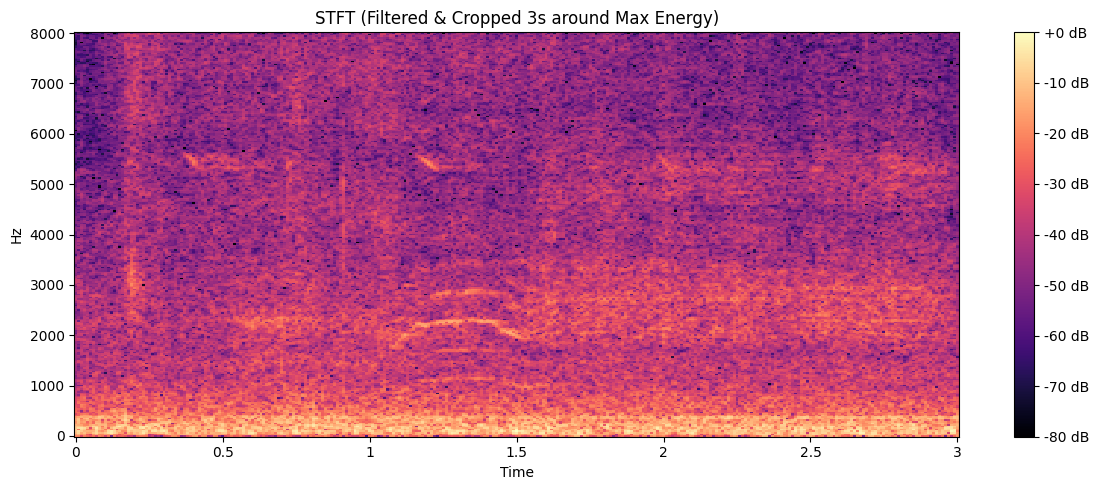

In [89]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import moviepy.editor as mp
import os
import numpy as np
from scipy.signal import butter, sosfilt
# 🎬 비디오에서 오디오 추출
video_path = "/content/20250502_164515_1_1.mp4"
audio_path = "/content/20250502_164515_1_1_audio.wav"
clip = mp.VideoFileClip(video_path)
clip.audio.write_audiofile(audio_path, fps=16000, verbose=False, logger=None)

# 🔊 오디오 로드
y, sr = librosa.load(audio_path, sr=16000)
print(f"✅ 오디오 로드 완료 - 총 길이: {len(y)/sr:.2f}초")

# 🧼 Band-pass filter: 20~12000Hz
def bandpass_filter(data, sr, lowcut=20.0, highcut=16000.0, order=5):
    sos = butter(order, [lowcut, highcut], btype='band', fs=sr, output='sos')
    return sosfilt(sos, data)

y_filtered = bandpass_filter(y, sr, lowcut=20.0, highcut=7999.0)

# 🔍 에너지가 가장 높은 3초 구간 추출
frame_length = int(0.05 * sr)  # 50ms
hop_length_energy = int(0.01 * sr)  # 10ms
energy = librosa.feature.rms(y=y_filtered, frame_length=frame_length, hop_length=hop_length_energy)[0]
energy_times = librosa.frames_to_time(np.arange(len(energy)), sr=sr, hop_length=hop_length_energy)

# 최대 에너지 시점 탐색
max_energy_index = np.argmax(energy)
center_time = energy_times[max_energy_index]
start_time = max(0, center_time - 1.5)  # 3초 구간의 중심
end_time = min(len(y_filtered)/sr, start_time + 3.0)

# 샘플 인덱스 변환
start_sample = int(start_time * sr)
end_sample = int(end_time * sr)
y_cropped = y_filtered[start_sample:end_sample]
print(f"🎯 잘라낸 구간: {start_time:.2f}초 ~ {end_time:.2f}초")

# 🎚️ STFT 시각화
n_fft = 512
hop_length = 160
D = librosa.stft(y_cropped, n_fft=n_fft, hop_length=hop_length)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure(figsize=(12, 5))
librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='linear', cmap='magma')
plt.colorbar(format="%+2.0f dB")
plt.title("STFT (Filtered & Cropped 3s around Max Energy)")
plt.tight_layout()
plt.show()

In [90]:
import cv2
import numpy as np
import librosa
import moviepy.editor as mp
from ultralytics import YOLO
import onnxruntime as ort
from scipy.signal import butter, sosfilt

# 경로 설정
video_path = '/content/20250502_164515_1_1.mp4'
audio_path = "/content/20250502_164515_1_1_audio.wav"

# 모델 로드
pose_model = YOLO('/content/drive/MyDrive/CAT_MULTI_MODEL/sampledata/11n_200_100.pt')
action_model = ort.InferenceSession('/content/drive/MyDrive/pyramid_fusion_model_middle_concat_last_3layer.onnx')

# 🎬 오디오 추출
clip = mp.VideoFileClip(video_path)
clip.audio.write_audiofile(audio_path, fps=16000, verbose=False, logger=None)

# 🔊 오디오 로드 및 필터링
y, sr = librosa.load(audio_path, sr=16000)

def bandpass_filter(data, sr, lowcut=20.0, highcut=7999.0, order=5):
    sos = butter(order, [lowcut, highcut], btype='band', fs=sr, output='sos')
    return sosfilt(sos, data)

y_filtered = bandpass_filter(y, sr)

# 🔍 에너지가 가장 큰 3초 구간 추출
frame_length = int(0.05 * sr)
hop_length_energy = int(0.01 * sr)
energy = librosa.feature.rms(y=y_filtered, frame_length=frame_length, hop_length=hop_length_energy)[0]
max_energy_index = np.argmax(energy)
center_time = librosa.frames_to_time(max_energy_index, sr=sr, hop_length=hop_length_energy)
start_time = max(0, center_time - 1.5)
end_time = min(len(y_filtered)/sr, start_time + 3.0)
y_cropped = y_filtered[int(start_time * sr):int(end_time * sr)]

# 🎚️ STFT 이미지 변환 (흑백 단일 채널 기준)
D = librosa.stft(y_cropped, n_fft=512, hop_length=160)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_db_norm = (S_db - S_db.min()) / (S_db.max() - S_db.min())
S_img = (S_db_norm * 255).astype(np.uint8)  # 흑백 이미지 (H, W)

# ✅ 단일 채널로 224x224 리사이즈
S_gray = cv2.resize(S_img, (224, 224))         # shape: (224, 224)
S_gray = S_gray.astype(np.float32) / 255.0     # 정규화 (0~1)

# ✅ 필요한 시점에만 3채널 확장
S_3ch = np.stack([S_gray] * 3, axis=0)          # shape: (3, 224, 224)
sound_input = S_3ch[np.newaxis, ...]            # shape: (1, 3, 224, 224)

print("✅ sound_input 최종 shape:", sound_input.shape)

# 🎥 관절 좌표 추출 (최대 100프레임)
cap = cv2.VideoCapture(video_path)
keypoints_list = []
target_center = None
frame_idx = 0
width, height = 640, 640

while cap.isOpened() and len(keypoints_list) < 100:
    ret, frame = cap.read()
    if not ret:
        break

    resized = cv2.resize(frame, (width, height))
    results = pose_model.predict(resized, save=False)
    result = results[0]

    if result.boxes is not None and len(result.boxes) > 0:
        boxes = result.boxes.xyxy.cpu().numpy()
        centers = [(int((x1+x2)/2), int((y1+y2)/2)) for x1,y1,x2,y2 in boxes]

        if frame_idx == 0:
            areas = [(x2 - x1)*(y2 - y1) for x1, y1, x2, y2 in boxes]
            target_idx = np.argmax(areas)
            target_center = centers[target_idx]
        else:
            dists = [np.linalg.norm(np.array(c) - np.array(target_center)) for c in centers]
            target_idx = np.argmin(dists)
            target_center = centers[target_idx]

        x1, y1, x2, y2 = boxes[target_idx]
        w, h = max(x2 - x1, 1e-5), max(y2 - y1, 1e-5)

        if result.keypoints is not None and len(result.keypoints.xy) > target_idx:
            kpts = result.keypoints.xy[target_idx].cpu().numpy()  # (15, 2)
            kpts[:, 0] = (kpts[:, 0] - x1) / w  # x 정규화
            kpts[:, 1] = (kpts[:, 1] - y1) / h  # y 정규화
            keypoints_list.append(kpts.T)  # (2, 15)

    frame_idx += 1

cap.release()

# ⏳ 프레임 수 정규화
if len(keypoints_list) == 0:
    raise ValueError("관절 정보가 추출되지 않았습니다.")

if len(keypoints_list) < 100:
    print(f"⚠️ 부족한 프레임 {len(keypoints_list)}개 → 반복 채워서 100개로")
    for i in range(100 - len(keypoints_list)):
        keypoints_list.append(keypoints_list[i % len(keypoints_list)])
elif len(keypoints_list) > 100:
    print(f"⚠️ 프레임이 너무 많습니다 ({len(keypoints_list)}개) → 앞에서부터 100개만 사용")
    keypoints_list = keypoints_list[:100]

pose_input = np.stack(keypoints_list, axis=1)  # (2, 100, 15)
pose_input = np.expand_dims(pose_input, axis=0).astype(np.float32)  # (1, 2, 100, 15)

# 🔍 ONNX 추론
outputs = action_model.run(None, {
    'pose_input': pose_input,
    'sound_input': sound_input
})

action_output = outputs[0]  # (1, 6)
emotion_output = outputs[1]  # (1, 4)

# 🎯 결과 출력
print("✅ 추론 완료")
print("🧠 행동 예측 (action_output):", action_output)
print("🧠 감정 예측 (emotion_output):", emotion_output)

action_labels = [
    "ARMSTRETCH",   # 0
    "GROOMING",     # 1
    "LAYDOWN",      # 2
    "SITDOWN",      # 3
    "TAILING",      # 4
    "WALKRUN"       # 5
]

emotion_labels = [
    "하악질",        # 0
    "편안",          # 1
    "골골송",        # 2
    "화남"           # 3
]


import torch

# 🔁 softmax 함수
def softmax(x):
    x = torch.tensor(x)
    return torch.nn.functional.softmax(x, dim=-1).numpy()

# softmax 적용
action_probs = softmax(action_output)[0]    # (6,)
emotion_probs = softmax(emotion_output)[0]  # (4,)

# 최고 확률 인덱스 추출
pred_action_idx = int(np.argmax(action_probs))
pred_emotion_idx = int(np.argmax(emotion_probs))

# 라벨 매핑
pred_action_label = action_labels[pred_action_idx]
pred_emotion_label = emotion_labels[pred_emotion_idx]

# 결과 출력
print(f"🎬 예측된 행동: {pred_action_label} (확률: {action_probs[pred_action_idx]:.2%})")
print(f"🎬 예측된 감정: {pred_emotion_label} (확률: {emotion_probs[pred_emotion_idx]:.2%})")

✅ sound_input 최종 shape: (1, 3, 224, 224)

0: 640x640 1 cat, 157.0ms
Speed: 5.0ms preprocess, 157.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 cat, 113.9ms
Speed: 2.8ms preprocess, 113.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 cat, 99.7ms
Speed: 11.3ms preprocess, 99.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 cat, 162.6ms
Speed: 12.2ms preprocess, 162.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 cat, 139.8ms
Speed: 19.8ms preprocess, 139.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 cat, 177.3ms
Speed: 17.0ms preprocess, 177.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 cat, 193.6ms
Speed: 2.5ms preprocess, 193.6ms inference, 16.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 cat, 105.9ms
Speed: 2.4ms preprocess, 105.9ms inference, 1.3ms post


0: 640x640 1 cat, 126.1ms
Speed: 3.3ms preprocess, 126.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
[0] ✅ 관절 추출 완료

0: 640x640 1 cat, 113.4ms
Speed: 4.0ms preprocess, 113.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
[1] ✅ 관절 추출 완료

0: 640x640 1 cat, 114.3ms
Speed: 3.8ms preprocess, 114.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
[2] ✅ 관절 추출 완료

0: 640x640 1 cat, 96.7ms
Speed: 2.0ms preprocess, 96.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
[3] ✅ 관절 추출 완료

0: 640x640 1 cat, 106.9ms
Speed: 8.7ms preprocess, 106.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
[4] ✅ 관절 추출 완료

0: 640x640 1 cat, 96.4ms
Speed: 3.7ms preprocess, 96.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
[5] ✅ 관절 추출 완료

0: 640x640 1 cat, 95.5ms
Speed: 2.6ms preprocess, 95.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
[6] ✅ 관절 추출 완료

0: 640x640 1 cat, 90.5ms


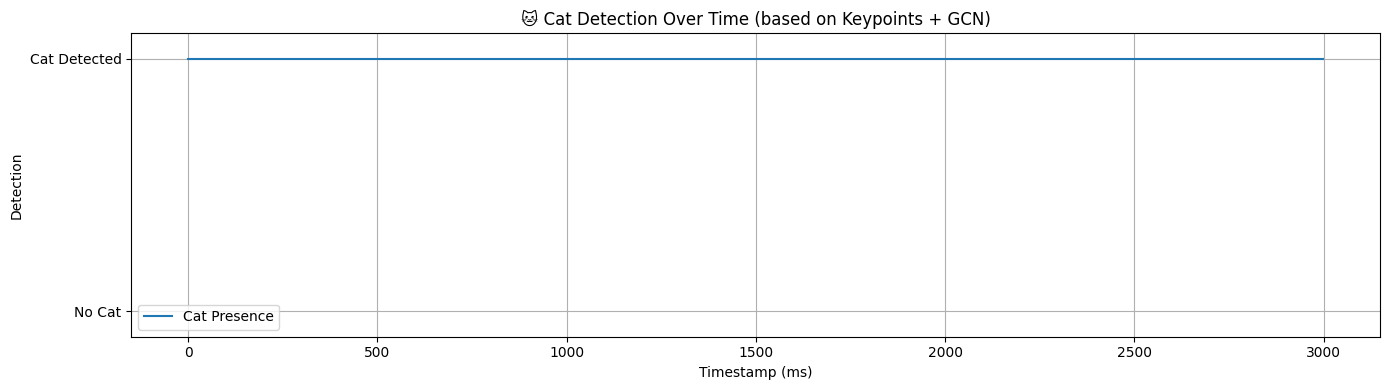

In [91]:
import cv2
import numpy as np
from ultralytics import YOLO
import onnxruntime as ort
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
# 설정
video_path = '/content/20250502_164515_1_1.mp4'
pose_model_path = '/content/drive/MyDrive/CAT_MULTI_MODEL/sampledata/11n_200_100.pt'
gcn_model_path = '/content/drive/MyDrive/cat_move/SimpleCTRGCN_final.onnx'

# 모델 로드
pose_model = YOLO(pose_model_path)
gcn_model = ort.InferenceSession(gcn_model_path)
gcn_input_name = gcn_model.get_inputs()[0].name

# 비디오 설정
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_duration_ms = 1000 / fps
width, height = 640, 640

# 1. YOLO로 관절 추출
keypoints_log = []
frame_idx = 0

start_time_ms = 0
end_time_ms = 8000

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    timestamp_ms = int(frame_idx * frame_duration_ms)
    if timestamp_ms < start_time_ms:
        frame_idx += 1
        continue
    elif timestamp_ms > end_time_ms:
        break

    resized = cv2.resize(frame, (width, height))
    results = pose_model.predict(resized, save=False)
    result = results[0]

    entry = {"frame_idx": frame_idx, "timestamp_ms": int(frame_idx * frame_duration_ms), "keypoints": None}

    if result.boxes is not None and len(result.boxes) > 0:
        boxes = result.boxes.xyxy.cpu().numpy()
        areas = [(x2 - x1)*(y2 - y1) for x1, y1, x2, y2 in boxes]
        target_idx = np.argmax(areas)
        x1, y1, x2, y2 = boxes[target_idx]
        w, h = max(x2 - x1, 1e-5), max(y2 - y1, 1e-5)

        if result.keypoints is not None and len(result.keypoints.xy) > target_idx:
            kpts = result.keypoints.xy[target_idx].cpu().numpy()
            if kpts.shape != (15, 2):
                print(f"[{frame_idx}] ❗ 좌표 개수 오류: {kpts.shape}")
            else:
                kpts[:, 0] = (kpts[:, 0] - x1) / w
                kpts[:, 1] = (kpts[:, 1] - y1) / h
                entry["keypoints"] = kpts.T.tolist()  # (2, 15)
                print(f"[{frame_idx}] ✅ 관절 추출 완료")

        else:
            print(f"[{frame_idx}] ❌ 박스는 있으나 keypoints 없음")

    else:
        print(f"[{frame_idx}] ⛔ 고양이 박스 없음")

    keypoints_log.append(entry)
    frame_idx += 1

cap.release()

# 2. CTR-GCN 후처리
buffer = []
output_log = []

for i, entry in enumerate(keypoints_log):
    ts = entry["timestamp_ms"]
    kpts = entry["keypoints"]

    if kpts is not None:
        buffer.append(kpts)
    else:
        output_log.append((ts, "None"))
        continue

    ready = False

    if len(buffer) == 100:
        pose_input = np.stack(buffer, axis=-1)  # (2, 15, 100)
        ready = True
    elif 30 <= len(buffer) < 100:
        # 반복해서 100프레임으로 확장
        repeat = buffer.copy()
        while len(repeat) < 100:
            repeat.append(buffer[len(repeat) % len(buffer)])
        pose_input = np.stack(repeat, axis=-1)
        ready = True

    if ready:
        pose_input = pose_input.transpose(2, 1, 0)         # (100, 15, 2)
        pose_input = pose_input.transpose(2, 0, 1)         # (2, 100, 15)
        pose_input = pose_input[np.newaxis, ..., np.newaxis].astype(np.float32)  # (1, 2, 100, 15, 1)

        # ONNX GCN 추론
        output = gcn_model.run(None, {gcn_input_name: pose_input})[0]  # (1, num_classes)
        output_tensor = torch.tensor(output[0])  # (num_classes,)

        probs = F.softmax(output_tensor, dim=0).numpy()  # softmax 확률값
        pred_class = int(np.argmax(probs))
        confidence = probs[pred_class]  # 확률값

        start_frame = i - len(buffer) + 1
        start_time = keypoints_log[start_frame]["timestamp_ms"]

        output_log.append((start_time, f"Action {pred_class} ({confidence:.2%})"))
        print(f"[{start_frame}] 🚀 GCN 추론 완료: Action {pred_class} ({confidence:.2%})")

        buffer = []

# 3. 결과 저장 및 시각화
df = pd.DataFrame(output_log, columns=["Timestamp(ms)", "Result"])
print(df.head(20))

# 시각화
timestamps = df["Timestamp(ms)"].tolist()
presence_flags = [0 if r == "None" else 1 for r in df["Result"]]

plt.figure(figsize=(14, 4))
plt.plot(timestamps, presence_flags, drawstyle='steps-post', label="Cat Presence")
plt.ylim(-0.1, 1.1)
plt.yticks([0, 1], ["No Cat", "Cat Detected"])
plt.xlabel("Timestamp (ms)")
plt.ylabel("Detection")
plt.title("🐱 Cat Detection Over Time (based on Keypoints + GCN)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [92]:
action_labels = [
    "ARMSTRETCH",   # 0
    "GROOMING",     # 1
    "LAYDOWN",      # 2
    "SITDOWN",      # 3
    "TAILING",      # 4
    "WALKRUN"       # 5
]


0: 640x640 1 cat, 115.9ms
Speed: 13.8ms preprocess, 115.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
[0] ✅ 관절 추출 완료

0: 640x640 1 cat, 89.8ms
Speed: 2.4ms preprocess, 89.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
[1] ✅ 관절 추출 완료

0: 640x640 1 cat, 104.5ms
Speed: 2.4ms preprocess, 104.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
[2] ✅ 관절 추출 완료

0: 640x640 1 cat, 103.9ms
Speed: 2.2ms preprocess, 103.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
[3] ✅ 관절 추출 완료

0: 640x640 1 cat, 125.6ms
Speed: 2.7ms preprocess, 125.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)
[4] ✅ 관절 추출 완료

0: 640x640 1 cat, 398.4ms
Speed: 3.2ms preprocess, 398.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
[5] ✅ 관절 추출 완료

0: 640x640 1 cat, 115.4ms
Speed: 2.5ms preprocess, 115.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
[6] ✅ 관절 추출 완료

0: 640x640 1 cat, 11

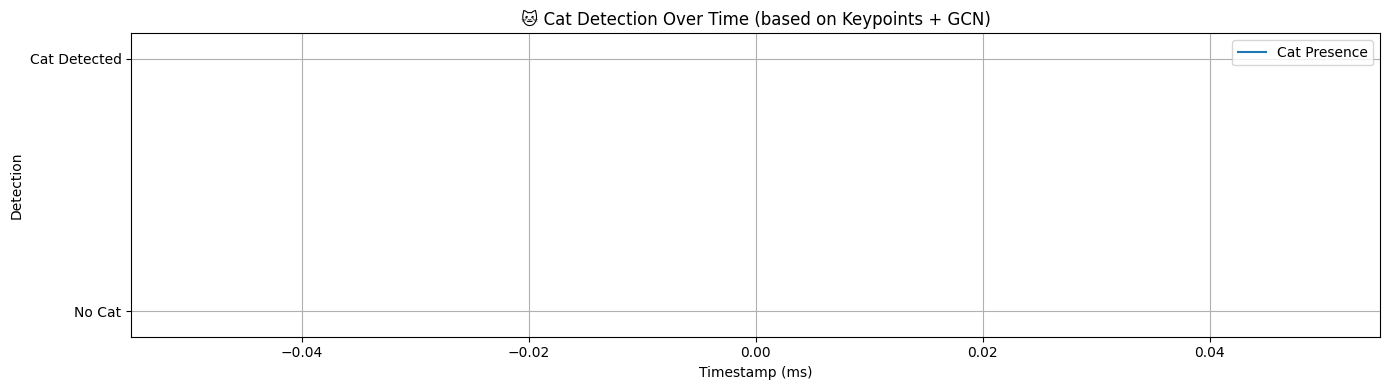

In [93]:
import cv2
import numpy as np
from ultralytics import YOLO
import onnxruntime as ort
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F

# 설정
video_path = '/content/20250502_164515_1_1.mp4'
pose_model_path = '/content/drive/MyDrive/CAT_MULTI_MODEL/sampledata/11n_200_100.pt'
gcn_model_path = '/content/drive/MyDrive/cat_move/SimpleCTRGCN_final.onnx'

# 모델 로드
pose_model = YOLO(pose_model_path)
gcn_model = ort.InferenceSession(gcn_model_path)
gcn_input_name = gcn_model.get_inputs()[0].name

# 비디오 설정
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_duration_ms = 1000 / fps
width, height = 640, 640

# 시작 및 종료 시간 (ms)
start_time_ms = 0
end_time_ms = 8000

# 가져올 프레임 인덱스 설정 (30fps 기준 간격으로 downsample)
selected_indices = []
frame_count = 0

# 먼저 프레임 총수 확인
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
total_duration_ms = total_frames * frame_duration_ms

while frame_count * frame_duration_ms <= total_duration_ms:
    current_time = frame_count * frame_duration_ms
    if start_time_ms <= current_time <= end_time_ms:
        selected_indices.append(frame_count)
    frame_count += int(fps / 30)  # 30fps 기준으로 프레임 간격 설정

# 1. YOLO로 관절 추출
keypoints_log = []
frame_idx = 0
current_index = 0

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

while cap.isOpened():
    if current_index >= len(selected_indices):
        break

    target_frame_idx = selected_indices[current_index]
    cap.set(cv2.CAP_PROP_POS_FRAMES, target_frame_idx)
    ret, frame = cap.read()
    if not ret:
        break

    timestamp_ms = int(target_frame_idx * frame_duration_ms)
    resized = cv2.resize(frame, (width, height))
    results = pose_model.predict(resized, save=False)
    result = results[0]

    entry = {"frame_idx": target_frame_idx, "timestamp_ms": timestamp_ms, "keypoints": None}

    if result.boxes is not None and len(result.boxes) > 0:
        boxes = result.boxes.xyxy.cpu().numpy()
        areas = [(x2 - x1)*(y2 - y1) for x1, y1, x2, y2 in boxes]
        target_idx = np.argmax(areas)
        x1, y1, x2, y2 = boxes[target_idx]
        w, h = max(x2 - x1, 1e-5), max(y2 - y1, 1e-5)

        if result.keypoints is not None and len(result.keypoints.xy) > target_idx:
            kpts = result.keypoints.xy[target_idx].cpu().numpy()
            if kpts.shape != (15, 2):
                print(f"[{target_frame_idx}] ❗ 좌표 개수 오류: {kpts.shape}")
            else:
                kpts[:, 0] = (kpts[:, 0] - x1) / w
                kpts[:, 1] = (kpts[:, 1] - y1) / h
                entry["keypoints"] = kpts.T.tolist()  # (2, 15)
                print(f"[{target_frame_idx}] ✅ 관절 추출 완료")
        else:
            print(f"[{target_frame_idx}] ❌ 박스는 있으나 keypoints 없음")
    else:
        print(f"[{target_frame_idx}] ⛔ 고양이 박스 없음")

    keypoints_log.append(entry)
    current_index += 1

cap.release()

# 2. CTR-GCN 후처리
buffer = []
output_log = []

for i, entry in enumerate(keypoints_log):
    ts = entry["timestamp_ms"]
    kpts = entry["keypoints"]

    if kpts is not None:
        buffer.append(kpts)

    if len(buffer) == 100:
        pose_input = np.stack(buffer, axis=-1)  # (2, 15, 100)
        pose_input = pose_input.transpose(2, 1, 0)         # (100, 15, 2)
        pose_input = pose_input.transpose(2, 0, 1)         # (2, 100, 15)
        pose_input = pose_input[np.newaxis, ..., np.newaxis].astype(np.float32)  # (1, 2, 100, 15, 1)

        # ONNX GCN 추론
        output = gcn_model.run(None, {gcn_input_name: pose_input})[0]  # (1, num_classes)
        output_tensor = torch.tensor(output[0])  # (num_classes,)

        probs = F.softmax(output_tensor, dim=0).numpy()  # softmax 확률값
        pred_class = int(np.argmax(probs))
        confidence = probs[pred_class]  # 확률값

        start_frame = i - len(buffer) + 1
        start_time = keypoints_log[start_frame]["timestamp_ms"]

        output_log.append((start_time, f"Action {pred_class} ({confidence:.2%})"))
        print(f"[{start_frame}] 🚀 GCN 추론 완료: Action {pred_class} ({confidence:.2%})")

        buffer = []

    elif kpts is None:
        output_log.append((ts, "None"))

# 3. 결과 저장 및 시각화
df = pd.DataFrame(output_log, columns=["Timestamp(ms)", "Result"])
print(df.head(20))

# 시각화
timestamps = df["Timestamp(ms)"].tolist()
presence_flags = [0 if r == "None" else 1 for r in df["Result"]]

plt.figure(figsize=(14, 4))
plt.plot(timestamps, presence_flags, drawstyle='steps-post', label="Cat Presence")
plt.ylim(-0.1, 1.1)
plt.yticks([0, 1], ["No Cat", "Cat Detected"])
plt.xlabel("Timestamp (ms)")
plt.ylabel("Detection")
plt.title("🐱 Cat Detection Over Time (based on Keypoints + GCN)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()